<a href="https://colab.research.google.com/github/gabi-bernardoni/Projeto-de-Mineracao-de-Textos/blob/main/BERTimbau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##BERTimbau

BERTimbau é uma versão em português do modelo BERT (Bidirectional Encoder Representations from Transformers), desenvolvido pela equipe do NeuralMind. Assim como o BERT, o BERTimbau é um modelo pré-treinado de linguagem baseado em Transformers que é eficaz para tarefas de processamento de linguagem natural (PLN). O modelo foi treinado com um grande corpus de textos em português.



##Funcionamento do Modelo

Primeiramente, o código carrega os dados a partir de um arquivo CSV. Em seguida, ele realiza o pré-processamento do texto para garantir que ele esteja limpo e formatado corretamente.
Depois de preparar o texto, o código utiliza LabelEncoder para transformar os rótulos de sentimento em números. Esse processo é necessário porque o modelo BERTimbau trabalha com dados numéricos para classificação. Com os dados preparados, o próximo passo é dividir o dataset em conjuntos de treinamento e teste.

O código então converte esses conjuntos de dados em um formato compatível com o modelo BERTimbau, utilizando a classe Dataset da biblioteca Hugging Face. O modelo BERTimbau é carregado juntamente com o tokenizer correspondente. O tokenizer é responsável por transformar o texto em tokens que o modelo pode entender, e o modelo é configurado para realizar a tarefa de classificação de texto, ajustado para o número de categorias de sentimento presentes.

O texto é tokenizado e formatado para o treinamento e avaliação, seguindo as especificações do modelo, como o comprimento máximo dos tokens. O treinamento é configurado com parâmetros como o número de épocas e o tamanho do batch. Usando a classe Trainer da Hugging Face, o modelo BERTimbau é ajustado no conjunto de treinamento.

O código também possui uma função para extrair embeddings das sentenças usando o modelo treinado. Esses embeddings são vetores que representam as características dos textos e podem ser utilizados para outras análises.

In [1]:
pip install datasets

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# Configurações
path_bert = 'neuralmind/bert-base-portuguese-cased'  # Modelo BERTimbau no Hugging Face
data_path = 'avaliacoes.csv'  # Caminho para o dataset

# Carregar e preparar os dados
df = pd.read_csv(data_path)

# Limpar e pré-processar o texto
import regex  # trabalhar com expressões regulares
df['content'] = df['content'].apply(lambda x: regex.sub('[^\p{Latin}]', u' ', str(x)))
df['content'] = df['content'].apply(lambda x: str(x).lower())

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(texto):
    stops_list = stopwords.words("portuguese")
    word_tokens = word_tokenize(texto)  #remove stopwords
    texto_sem_stops = [w for w in word_tokens if w not in stops_list]
    return " ".join(texto_sem_stops)

df['content'] = df['content'].apply(remove_stopwords)

# Codificar os rótulos
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])
df['content'] = df['content'].astype(str)  #  texto como string

# Dividir os dados
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_dataset = Dataset.from_pandas(train_df[['content', 'label']])
test_dataset = Dataset.from_pandas(test_df[['content', 'label']])

# Carregar o tokenizer e o modelo
tokenizer = BertTokenizer.from_pretrained(path_bert)
model = BertForSequenceClassification.from_pretrained(path_bert, num_labels=len(label_encoder.classes_))  # Número de classes

# Função de pré-processamento
def preprocess_function(examples):
    return tokenizer(examples['content'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Configuração do Trainer
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Treinamento
trainer.train()

# Avaliação
eval_results = trainer.evaluate()

print("Avaliação do Modelo:")
print(eval_results)

# Obtenção dos embeddings
def get_embeddings(texts, tokenizer, model, batch_size=32, max_length=128):
    model.eval()
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            outputs = model.bert(**inputs)  # Usar o modelo BERT para obter embeddings
            embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Pegar embeddings da [CLS] token
            all_embeddings.extend(embeddings)
    return np.array(all_embeddings)

# Gerar embeddings
embeddings = get_embeddings(df['content'].tolist(), tokenizer, model)

print("Shape dos embeddings:", embeddings.shape)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2408 [00:00<?, ? examples/s]

Map:   0%|          | 0/603 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.817792
2,0.909400,0.830763
3,0.909400,0.975487


Avaliação do Modelo:
{'eval_loss': 0.9754871726036072, 'eval_runtime': 258.6509, 'eval_samples_per_second': 2.331, 'eval_steps_per_second': 0.294, 'epoch': 3.0}
Shape dos embeddings: (3011, 768)


In [13]:
# Previsões do modelo para o conjunto de teste
predictions = trainer.predict(test_dataset)
predicoes = np.argmax(predictions.predictions, axis=1)

In [14]:
# Extrair os rótulos verdadeiros do conjunto de teste
y_test = np.array(test_df['label'])

In [15]:
from sklearn.metrics import classification_report

print("Relatório de Classificação:")
print(classification_report(y_test, predicoes, target_names=label_encoder.classes_))

Relatório de Classificação:
              precision    recall  f1-score   support

       anger       0.76      0.72      0.74       149
     disgust       0.67      0.68      0.67       191
        fear       0.00      0.00      0.00         9
   happiness       0.86      0.67      0.75        64
     neutral       0.09      0.06      0.07        16
     sadness       0.72      0.86      0.78       173
    surprise       0.00      0.00      0.00         1

    accuracy                           0.71       603
   macro avg       0.44      0.43      0.43       603
weighted avg       0.70      0.71      0.70       603



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


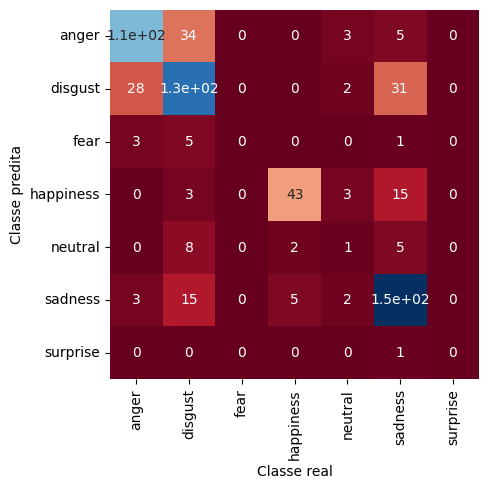

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predicoes)
categorias = label_encoder.classes_
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
            xticklabels=categorias,
            yticklabels=categorias)

plt.xlabel("Classe real")
plt.ylabel("Classe predita")
plt.show()


In [21]:
# Salvar o modelo e o tokenizer
model.save_pretrained('./results')
tokenizer.save_pretrained('./results')

# Salvar o LabelEncoder
import joblib
joblib.dump(label_encoder, './results/label_encoder.pkl')

['./results/label_encoder.pkl']

Vantagens:

Desempenho em Linguagem Portuguesa: BERTimbau é treinado para o português, o que permite um melhor entendimento;


Limitações:

Requisitos Computacionais: Exigem uma quantidade significativa de memória RAM e poder de processamento;

Tempo de Treinamento: O treinamento com o BERTimbau é demorado.

##Análise de 3 novos sentimentos que não estão no arquivo.csv

In [24]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import joblib
import pandas as pd

# Caminho para o modelo treinado, tokenizer e LabelEncoder
path_bert = 'neuralmind/bert-base-portuguese-cased'
model_path = './results'
label_encoder_path = './results/label_encoder.pkl'

# Carregar o tokenizer, o modelo e o LabelEncoder
tokenizer = BertTokenizer.from_pretrained(path_bert)
model = BertForSequenceClassification.from_pretrained(model_path)
label_encoder = joblib.load(label_encoder_path)

# Novos comentários para análise
novos_comentarios = [
    "Eu simplesmente amei, achei minha cara. É bem gostosinho e bem quentinho.",  #Comentário SHEIN
    "Fiz o teste de qualidade pelo congelamento e infelizmente a cápsula congelou, mesmo tendo o selo meg3. Escolhi com tanto cuidado e não gostei do resultado..", #Comentário Amazon
    "Produto de boa qualidade, tudo certo.." #Comentário Casas Bahia
]

# Função de pré-processamento
def preprocess_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

# Tokenizar os novos comentários
inputs = preprocess_function(novos_comentarios)

# Fazer as previsões
model.eval()  # Coloca o modelo em modo de avaliação
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Obter as previsões
predicoes = torch.argmax(logits, dim=1).numpy()

# Mapear as previsões de volta para as categorias
categorias = label_encoder.classes_
resultados = categorias[predicoes]

# Exibir os resultados
for comentario, resultado in zip(novos_comentarios, resultados):
    print(f"Comentário: {comentario}\nSentimento Predito: {resultado}\n")



Comentário: Eu simplesmente amei, achei minha cara. É bem gostosinho e bem quentinho.
Sentimento Predito: happiness

Comentário: Fiz o teste de qualidade pelo congelamento e infelizmente a cápsula congelou, mesmo tendo o selo meg3. Escolhi com tanto cuidado e não gostei do resultado..
Sentimento Predito: disgust

Comentário: Produto de boa qualidade, tudo certo..
Sentimento Predito: happiness

